### AIPM -  MiniProject - CH22M503

#### Author - Aloy Banerjee
###### Roll No. CH22M503

#### Importing Library

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###### Problem - 1: Kalman Filter
###### Implement the Kalman Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. The experiment is explained in detail in the reference paper (Quadruple tank process) as in the link given below.
###### Link: https://drive.google.com/file/d/1XQ-O1Rov4L_b6n1J6dJQ7_3cUy-l-ik4/view?usp=sharing
###### Please use the same parameter values as described in the paper. For the initial conditions, use the minimum-phase characteristic values. The transfer functions given in the paper can be ignored for this assignment. Q and R values have to be tuned to attain convergence of the filter and get better accuracy with the estimates. Tolerance, defined as the L2 norm between prior and posterior state vectors, has to be less than or equal to 5 X 10-3. Measurements are sampled at a time interval of 0.1s. Measurement values obtained by solving the model equations have also been uploaded in the link given below. Use them as the true measurements.
###### Link: https://docs.google.com/spreadsheets/d/10lm7KOxo6k3etXTsW5t2KYcC7d0sGUlZ/edit?usp=sharing&ouid=108491382124139074371&rtpof=true&sd=true

#### Reference used 

#### Loading the data

In [52]:
# Load the data from an Excel file
tank_measurement_data = pd.read_excel('Link 2 Measurements.xlsx')
print(tank_measurement_data)

              h1         h2        h3        h4
0      12.400000  12.700000  1.800000  1.400000
1      12.404928  12.700618  1.792881  1.400301
2      12.409478  12.701239  1.786060  1.400592
3      12.413670  12.701863  1.779526  1.400873
4      12.417521  12.702490  1.773266  1.401145
...          ...        ...       ...       ...
9996   12.262968  12.783158  1.633941  1.409045
9997   12.262968  12.783158  1.633941  1.409045
9998   12.262968  12.783158  1.633941  1.409045
9999   12.262968  12.783158  1.633941  1.409045
10000  12.262968  12.783158  1.633941  1.409045

[10001 rows x 4 columns]


#### Seperate each tank measurement 

In [53]:
# Separate the measurements for each tank
tank1_measurements = tank_measurement_data['h1'].values
tank2_measurements = tank_measurement_data['h2'].values
tank3_measurements = tank_measurement_data['h3'].values
tank4_measurements = tank_measurement_data['h4'].values

#### Display the result

In [54]:
print(tank1_measurements)
print(tank2_measurements)
print(tank3_measurements)
print(tank4_measurements)

[12.4        12.40492766 12.40947845 ... 12.26296752 12.26296752
 12.26296752]
[12.7        12.70061798 12.70123915 ... 12.7831584  12.7831584
 12.7831584 ]
[1.8        1.79288086 1.78606001 ... 1.63394113 1.63394113 1.63394113]
[1.4        1.40030108 1.40059211 ... 1.4090447  1.4090447  1.4090447 ]


#### Common variable declaration

#### Kalman Filter

In [55]:
# Simulation of Kalman Filter Based on The Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero
# Karl Henrik Johansson. Parameter Initialization

n = 4  # number of states
m = 2  # number of observations

A1 = A3 = 28
A2 = A4 = 32

a1 = a3 = 0.071
a2 = a4 = 0.057

kc = 0.5
g = 981

gamma1 = 0.7
gamma2 = 0.6

k1 = 3.33
k2 = 3.35

v1 = v2 = 3
h0 = tank_measurement_data.to_numpy()[0,:]

T1 = (A1/a1) * np.sqrt((2 * h0[0]) / g) 
T2 = (A2/a2) * np.sqrt((2 * h0[1]) / g) 
T3 = (A3/a3) * np.sqrt((2 * h0[2]) / g) 
T4 = (A4/a4) * np.sqrt((2 * h0[3]) / g) 

state_transition_matrix = np.array([[-1/T1, 0, A3/(A1*T3), 0],[0, -1/T2, 0, A4/(A2*T4)],[0, 0, -1/T3, 0],[0, 0, 0, -1/T4]])    
control_input_matrix = np.array([[gamma1 * k1/A1, 0], [0, gamma2 * k2/A2], [0, (1 - gamma2) * k2 / A3], [(1 - gamma2) * k2 / A3, 0]])
observation_matrix = np.array([[kc, 0, 0, 0], [0, kc, 0, 0]])
control_input = np.array([-v1, v2]).reshape(2, 1)


#hyperparameter - can be change to achieve the accuracy
process_noise_cov = np.eye(n) * 0.1  # replace 0.1 with your estimate of process noise
measurement_noise_cov = np.eye(m) * 0.1  # replace 0.1 with your estimate of measurement noise 

initial_state = np.ones((n, 1))#np.ones(n)  # initial state estimate
error_cov = 1e5 * np.eye(n)  # initial error covariance


#### Particle Filter

In [56]:
# particles for our particle filter
number_of_particles = 1000 
# replace this with your method for initializing particles
initial_particles = np.random.rand(number_of_particles, n)  
 # start with equal confidence in all particles : Initialize weights
initial_weights = np.ones(number_of_particles) / number_of_particles

#### Common function

In [57]:
def kalman_filter_simulation(z, u, F, B, H, Q, R, P, x):
    """
    Implements the Kalman filter for a linear system.
    
    Parameters:
    z (np.array): Vector of measurements for each time step.
    u (np.array): Control vector.
    F (np.array): State transition matrix.
    B (np.array): Observation model matrix.
    Q (np.array): Process noise covariance.
    R (np.array): Observation noise covariance.
    P (np.array): Error covariance matrix.
    x (np.array): Initial state estimate.

    Returns:
    x_estimates (np.array): Estimated state for each time step.
    P (np.array): Final error covariance matrix.
    """

    # Initialize matrix to hold state estimates for each time step
    n = len(x)  # number of states
    N = len(z)  # number of time steps
    x_estimates = np.zeros((N, n))  # one row for each time step, one column for each state    
    for i in range(N):
        x = np.dot(F, x) + np.dot(B, u[:].reshape(-1, 1))
        P = np.dot(np.dot(F, P), F.T) + Q
        # Update step
        K = np.dot(np.dot(P, H.T), np.linalg.inv(np.dot(np.dot(H, P), H.T) + R))
        Z_est = np.dot(H, x)
        E = z[i,:2] - Z_est.flatten()
        x = x + np.dot(K, E.reshape(-1, 1))
        P = P - np.dot(np.dot(K, H), P)
        # Store the state estimate for this time step
        x_estimates[i] = x.flatten()

    # Return the state estimates for all time steps and the final error covariance
    return x_estimates, P



def particle_filter(N, z, particles, weights):
    """
    Implements the Particle filter for a system.
    
    Parameters:
    N (int): Number of particles.
    z (np.array): Vector of measurements for each time step.
    particles (np.array): Initial set of particles.
    weights (np.array): Initial weights of particles.

    Returns:
    x_estimates (np.array): Estimated state for each time step.
    """

    # Initialize matrix to hold state estimates for each time step
    n = particles.shape[1]  # number of states (i.e., dimension of a particle)
    Nt = len(z)  # number of time steps
    x_estimates = np.zeros((Nt, n))  # one row for each time step, one column for each state

    for i in range(Nt):
        # Predict step: move particles based on system dynamics
        particles = predict(particles)  # You need to define the predict function based on your process model

        # Update step: update weights based on measurement
        weights = update(particles, z[i], weights)  # You need to define the update function based on your measurement model

        # Resampling step: create a new set of particles
        particles = resample(particles, weights)  # Resample particles based on weights
        
        # Compute the weighted average of particles as the state estimate for this time step
        x_estimates[i] = np.average(particles, weights=weights, axis=0)

    # Return the state estimates for all time steps
    return x_estimates

def predict(particles):
    """
    Predicts the next state of the particles based on the system dynamics.
    
    Parameters:
    particles (np.array): The current state of the particles.

    Returns:
    particles (np.array): The predicted state of the particles.
    """
    # Add some process noise to each particle to represent uncertainty in the system dynamics
    # This step is based on the assumption that the particles follow a Gaussian distribution and 
    # the process noise is also Gaussian. The predict function simply adds some Gaussian noise 
    # to each particle which simulates the effect of process noise in the system.
    particles += np.random.normal(0, 0.1, particles.shape)  # Replace 0.1 with your own estimate of process noise

    # Returns the updated particles after adding the process noise
    return particles

def update(particles, z, weights):
    """
    Updates the weights of the particles based on the measurement.

    Parameters:
    particles (np.array): The current state of the particles.
    z (float): The current measurement.
    weights (np.array): The current weights of the particles.

    Returns:
    weights (np.array): The updated weights of the particles.
    """

    for i in range(len(particles)):
        # Calculate the difference between the predicted state (particle) and the actual measurement
        # This difference, or residual, is used to update the weight of the particle
        diff = z - particles[i]

        # Update the weight of this particle based on the difference
        # The weight is updated using the Gaussian probability density function, assuming the measurement noise is Gaussian
        # The larger the difference between the particle and the measurement, the smaller the weight will be
        # Replace this with your own noise model if necessary
        weights[i] = np.exp(-0.5 * np.dot(diff, diff))

    # Normalize the weights so they sum to 1
    # This is necessary as the weights represent the relative probability of each particle
    weights /= sum(weights)

    # Return the updated weights
    return weights

def resample(particles, weights):
    """
    Resamples the particles based on their weights.
    
    Parameters:
    particles (np.array): The current state of the particles.
    weights (np.array): The current weights of the particles.

    Returns:
    particles (np.array): The resampled particles.
    """

    # Generate a set of indices for resampling. Indices are chosen randomly, 
    # but particles with higher weights are more likely to be chosen. 
    # The size of the resampled array is the same as the original array of particles.
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)

    # Resample the particles based on the generated indices
    # The resampled array of particles contains duplicates of the same particle if that particle's weight is high
    particles = particles[indices]

    # Reset all weights to be equal
    # This is done because after resampling, all particles are equally likely (they've survived the 'survival of the fittest')
    weights = np.ones_like(weights) / len(particles)

    # Return the resampled particles
    return particles

def plot_tank_data(subplot_index, time_steps, tank_measurements, kalman_results, particle_results, tank_title):
    """
    Plots the tank measurements, Kalman Filter results, and Particle Filter results on a 2x2 subplot.

    Args:
        subplot_index (int): The index of the subplot where this tank's data will be plotted.
        time_steps (array): An array representing the time steps.
        tank_measurements (array): An array of the original measurements for this tank.
        kalman_results (array): The results of the Kalman filter for this tank.
        particle_results (array): The results of the Particle filter for this tank.
        tank_title (str): The title for the subplot.
    """
    # Create a subplot on a 2x2 grid at the specified index
    plt.subplot(2, 2, subplot_index)
    
    # Plot the original tank measurements against time steps, label it as 'Original'
    plt.plot(time_steps, tank_measurements, label='Original')
    
    # Plot the Kalman Filter results against time steps, label it as 'Kalman Filter'
    plt.plot(time_steps, kalman_results, label='Kalman Filter')
    
    # Plot the Particle Filter results against time steps, label it as 'Particle Filter'
    plt.plot(time_steps, particle_results, label='Particle Filter')
    
    # Set the title for this subplot to be the provided tank title
    plt.title(tank_title)
    
    # Add a legend to the subplot
    plt.legend()

    
def plot_filterwise_tank_data(subplot_num, time_steps, original_data, filter_results, tank_measurements, tank_name, marker):
    """
    Plots the tank data for a specific filter.

    Parameters:
        subplot_num (int): The subplot number for the current tank.
        time_steps (numpy.ndarray): Array of time steps.
        original_data (numpy.ndarray): Array of original tank data.
        filter_results (numpy.ndarray): Array of filter results for the current tank.
        tank_measurements (numpy.ndarray): Array of tank measurements for the current tank.
        tank_name (str): Name of the current tank.
        marker (str): Marking the tank wise plot

    Returns:
        None
    """
    # Create a subplot for the current tank
    plt.subplot(2, 2, subplot_num) 
    # Plot the original tank data
    plt.plot(time_steps, original_data, label='Original Data', color='blue')  
    # Plot the filter results
    plt.plot(time_steps, filter_results, label='Filter Results', color='red')  
    # Plot the tank measurements
    plt.scatter(time_steps, tank_measurements, label='Measurements', color='green', marker=marker, s = 30) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel('Tank Level') 
    # Set the title for the subplot
    plt.title(tank_name)  
    # Show the legend
    plt.legend()  

#### Set up the time steps based on the length of the measurement dataset

In [58]:
# Create a time vector
time_steps = np.arange(len(tank1_measurements))
# Your measurements from the system
measurements = np.array([tank1_measurements, tank2_measurements, tank3_measurements, tank4_measurements]).T
time_steps = np.arange(len(tank1_measurements))

#### Calling Kalman filter function for estimation

In [59]:
# Call the Kalman filter function
# kalman_filter_results, _ = kalman_filter(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov, error_cov, initial_state)
kalman_filter_results, _ = kalman_filter_simulation(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov, error_cov, initial_state)

#### Plotting the Kalman filter estimates over each time steps 

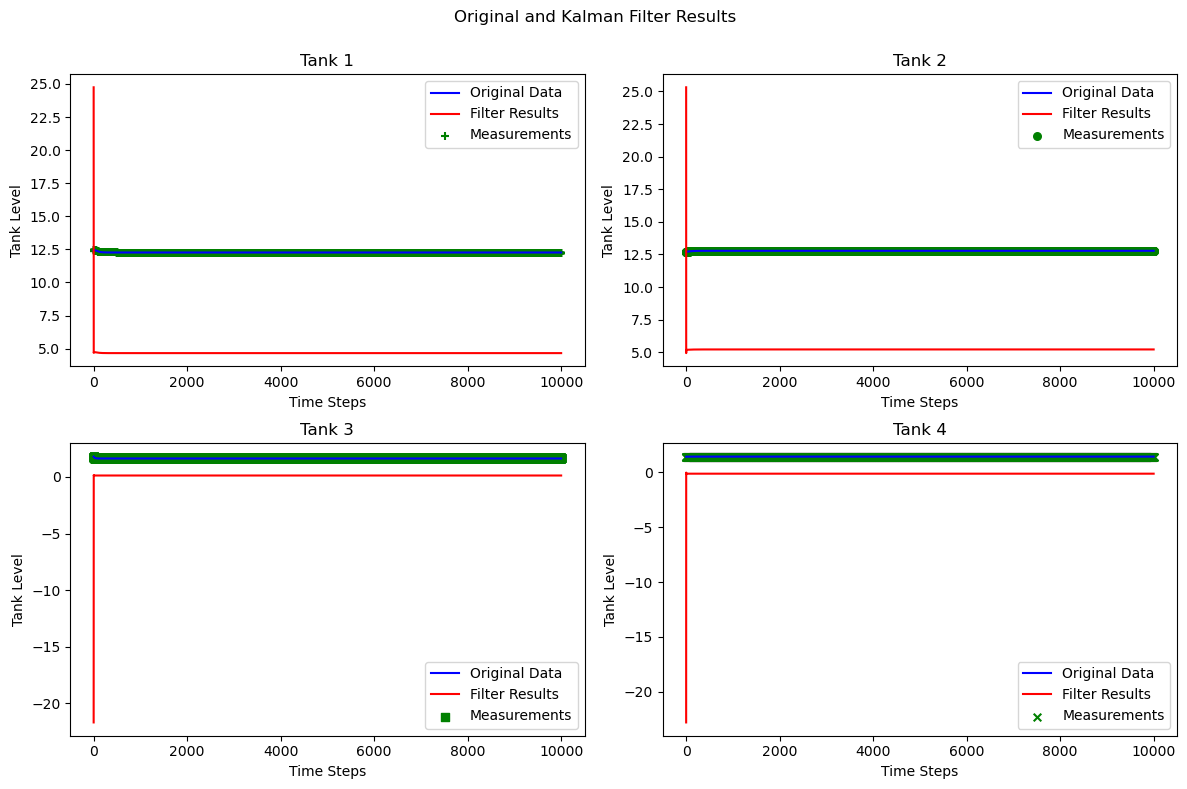

In [60]:
# Initialize the plot for original data and Kalman filter results
plt.figure(figsize=(12, 8))
plt.suptitle('Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, kalman_filter_results[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, kalman_filter_results[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, kalman_filter_results[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, kalman_filter_results[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

###### Problem - 2: Particle filter
###### Implement the Particle Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. Follow the same procedures as mentioned in Problem 1.

#### Calling Particle filter function for estimation

In [61]:
# Call the Particle filter function
particle_filter_results = particle_filter(number_of_particles, measurements, initial_particles, initial_weights)

#### Plotting the Particle filter estimates over each time steps 

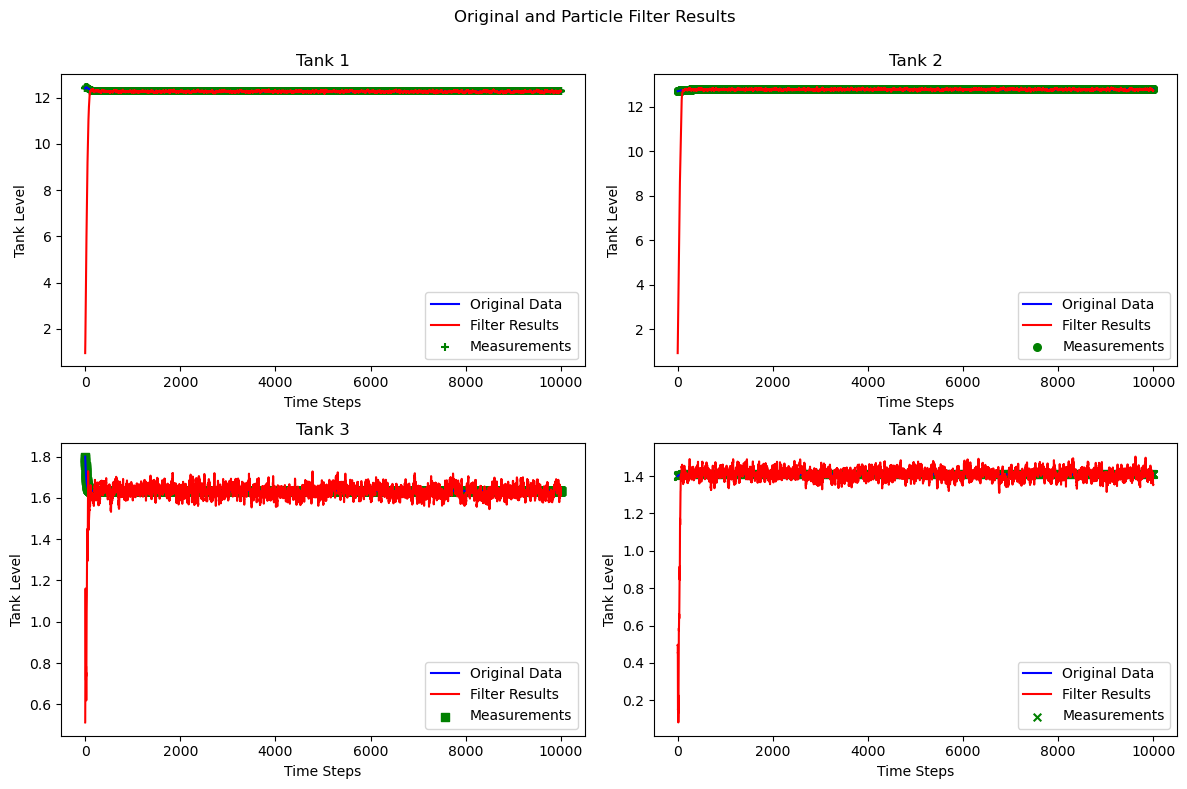

In [62]:
# Initialize the plot for original data and Particle filter results
plt.figure(figsize=(12, 8))
plt.suptitle('Original and Particle Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, particle_filter_results[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, particle_filter_results[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, particle_filter_results[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, particle_filter_results[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

###### Problem - 3: Comparison
###### Compare the results obtained from Part 1 and 2 with the actual measured values and document your inferences.

#### Plot the result for both Kalman Filter and Particle Filter

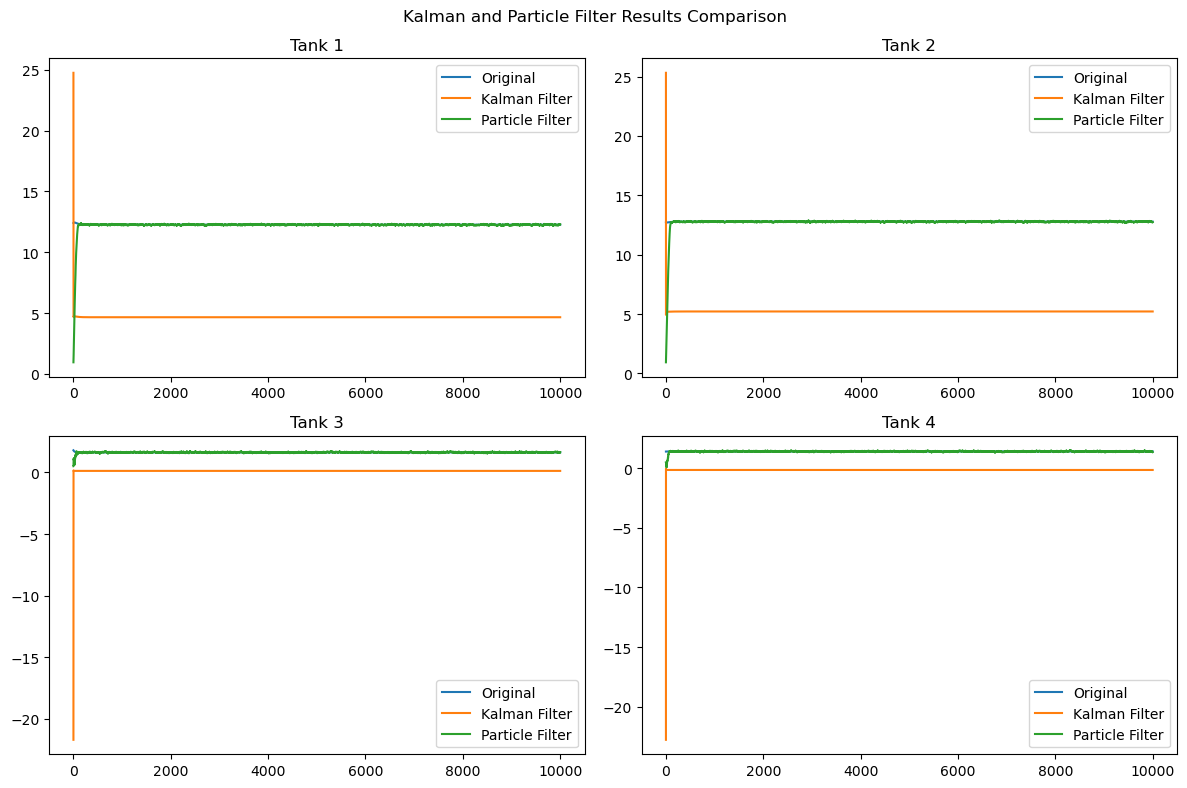

In [63]:
# Initialize the plot
plt.figure(figsize=(12, 8))
plt.suptitle('Kalman and Particle Filter Results Comparison')
# Plotting the Kalman Filter and Particle Filter Measurement 
plot_tank_data(1, time_steps, tank1_measurements, kalman_filter_results[:, 0], particle_filter_results[:, 0], 'Tank 1')
plot_tank_data(2, time_steps, tank2_measurements, kalman_filter_results[:, 1], particle_filter_results[:, 1], 'Tank 2')
plot_tank_data(3, time_steps, tank3_measurements, kalman_filter_results[:, 2], particle_filter_results[:, 2], 'Tank 3')
plot_tank_data(4, time_steps, tank4_measurements, kalman_filter_results[:, 3], particle_filter_results[:, 3], 'Tank 4')


# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.show()


#### Tabularize the data for better visibility and comparison between the convergence between Kalman and Particle Filter estimation

In [64]:
# Create a dataframe with the results
results_dataframe = pd.DataFrame({
    'Time_Step': time_steps,
    'Original_Tank1_Reading': tank1_measurements,
    'KalmanFilter_Tank1_Estimate': kalman_filter_results[:, 0],
    'ParticleFilter_Tank1_Estimate': particle_filter_results[:, 0],
    'Original_Tank2_Reading': tank2_measurements,
    'KalmanFilter_Tank2_Estimate': kalman_filter_results[:, 1],
    'ParticleFilter_Tank2_Estimate': particle_filter_results[:, 1],
    'Original_Tank3_Reading': tank3_measurements,
    'KalmanFilter_Tank3_Estimate': kalman_filter_results[:, 2],
    'ParticleFilter_Tank3_Estimate': particle_filter_results[:, 2],
    'Original_Tank4_Reading': tank4_measurements,
    'KalmanFilter_Tank4_Estimate': kalman_filter_results[:, 3],
    'ParticleFilter_Tank4_Estimate': particle_filter_results[:, 3]
})

# Display the dataframe
display(results_dataframe)


,Time_Step,Original_Tank1_Reading,KalmanFilter_Tank1_Estimate,ParticleFilter_Tank1_Estimate,Original_Tank2_Reading,KalmanFilter_Tank2_Estimate,ParticleFilter_Tank2_Estimate,Original_Tank3_Reading,KalmanFilter_Tank3_Estimate,ParticleFilter_Tank3_Estimate,Original_Tank4_Reading,KalmanFilter_Tank4_Estimate,ParticleFilter_Tank4_Estimate
0,0,12.400000,24.750238,0.953358,12.700000,25.318690,0.937923,1.800000,-21.695773,0.512058,1.400000,-22.773594,0.495427
1,1,12.404928,5.293784,1.053661,12.700618,4.937280,1.108324,1.792881,-0.899362,0.513580,1.400301,-0.047424,0.497131
2,2,12.409478,4.678645,1.186116,12.701239,5.192050,1.343278,1.786060,0.168154,0.614851,1.400592,-0.148498,0.452574
3,3,12.413670,4.719501,1.392339,12.701863,5.186455,1.462163,1.779526,0.127697,0.843287,1.400873,-0.144248,0.454670
4,4,12.417521,4.719160,1.552293,12.702490,5.186867,1.769145,1.773266,0.129395,1.049500,1.401145,-0.144389,0.195144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9996,12.262968,4.658083,12.270681,12.783158,5.218874,12.728091,1.633941,0.129431,1.608255,1.409045,-0.144419,1.359566
9997,9997,12.262968,4.658083,12.260249,12.783158,5.218874,12.729273,1.633941,0.129431,1.611069,1.409045,-0.144419,1.351150
9998,9998,12.262968,4.658083,12.263913,12.783158,5.218874,12.743138,1.633941,0.129431,1.616446,1.409045,-0.144419,1.356250
9999,9999,12.262968,4.658083,12.260937,12.783158,5.218874,12.738321,1.633941,0.129431,1.627590,1.409045,-0.144419,1.359781


#### Saving the compared data between Kalman and Particle Filter estimates

In [65]:
results_dataframe.to_csv('Comparison_New.csv', sep=',', index=False, encoding='utf-8')

#### ===================End of Mini Project===============================